# STOCK MARKET ANALYSIS AND PREDICTION USING LSTM

name-Rajrishi Sarkar  
roll-203110061  
ee769 project  

**Dataset consists of following files:**   

**prices.csv:** raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140   stock splits in that time, this set doesn't account for that.
prices-split-adjusted.csv: same as prices, but there have been added adjustments for splits.  
    
**securities.csv:** general description of each company with division on sectors
    
**fundamentals.csv:** metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.  

__________________________________________________________________________________________________________________________________________________________________

## Importing the basic libraries

In [1]:
#basic libs
import pandas as pd
import numpy as np

#visualizing libs
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme="monokai",context="notebook",ticks=True,grid=True)

#deep learning libs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

#stats libs
from scipy import stats

#preprocessing libs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#warnings 
import warnings
warnings.filterwarnings("ignore")

__________________________________________________________________________________________________________________________________________________________________

## Importing files

In [2]:
df=pd.read_csv("prices.csv")

_________________________________________________________________________________________________________________________________________________________________

## Checking the dataset

In [3]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
df.shape

(851264, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [6]:
#checking for missing values
df.isna().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

there are no missing values in the dataset

In [7]:
# data satatistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,851264.0,7.083699e+01,8.369588e+01,0.85,3.384000e+01,5.277000e+01,7.988000e+01,1.584440e+03
close,851264.0,7.085711e+01,8.368969e+01,0.86,3.385000e+01,5.280000e+01,7.989000e+01,1.578130e+03
low,851264.0,7.011841e+01,8.287729e+01,0.83,3.348000e+01,5.223000e+01,7.911000e+01,1.549940e+03
high,851264.0,7.154348e+01,8.446550e+01,0.88,3.419000e+01,5.331000e+01,8.061000e+01,1.600930e+03
volume,851264.0,5.415113e+06,1.249468e+07,0.00,1.221500e+06,2.476250e+06,5.222500e+06,8.596434e+08


In [8]:
# lets check the number of companies in the dataset
len(df["symbol"].unique())

501

501 companies are listed in the stock dataset

________________________________________________________________________________________________________________________________________________________

### Sampling the dataset for the company  "APPLE"

At the moment we are precisely iteresteed in the stock prices variation of "apple".So we will be sampling all the apple datas from the given dataset and proceed further

In [9]:
#AAPL is the symbol for apple in NYSE so we will be separating our dataset for apple precisely on the basis of this 
df1=df[df["symbol"]=="AAPL"]
df1.head()

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0
721,2010-01-05,AAPL,214.599998,214.379993,213.249994,215.589994,150476200.0
1189,2010-01-06,AAPL,214.379993,210.969995,210.750004,215.230000,138040000.0
1657,2010-01-07,AAPL,211.750000,210.580000,209.050005,212.000006,119282800.0
2125,2010-01-08,AAPL,210.299994,211.980005,209.060005,212.000006,111902700.0


In [10]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
open,1762.0,3.130763e+02,1.852995e+02,9.000000e+01,1.152225e+02,3.182300e+02,4.708800e+02,7.024100e+02
close,1762.0,3.129271e+02,1.851471e+02,9.028000e+01,1.151900e+02,3.182400e+02,4.725925e+02,7.021000e+02
low,1762.0,3.098282e+02,1.833839e+02,8.947000e+01,1.140025e+02,3.165450e+02,4.679725e+02,6.995700e+02
high,1762.0,3.159113e+02,1.868982e+02,9.070000e+01,1.163625e+02,3.206000e+02,4.781100e+02,7.050700e+02
volume,1762.0,9.422578e+07,6.020519e+07,1.147590e+07,4.917478e+07,8.050385e+07,1.210816e+08,4.702495e+08


In [11]:
df1.shape

(1762, 7)

In [12]:
#converting date to date time
df1["date"]=pd.to_datetime(df1["date"])

_________________________________________________________________________________________________

# Exploratory data analysis

**Visualising the stock opening and closing prices over the period of 6 years**

Text(0.5, 1.0, 'Closing prices from 2010-17')

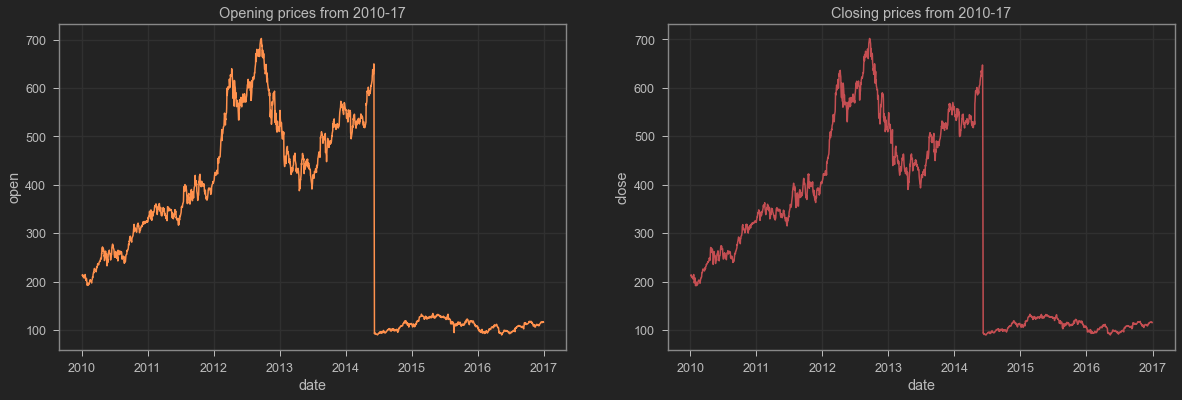

In [13]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=df1,x="date",y="open",ax=ax[0],color="y").set_title("Opening prices from 2010-17")
sns.lineplot(data=df1,x="date",y="close",ax=ax[1],color="r").set_title("Closing prices from 2010-17")

**Visualizing the stock volume**

Volume is counted as the total number of shares that are actually traded (bought and sold) during the trading day or specified set period of time. It is a measure of the total turnover of shares. Each ticket represents a trade and counted towards the total trading volume. While the same shares may be traded back and forth multiple times, the volume is counted on each transaction.

Text(0.5, 1.0, 'Variation in stock volume of apple from 2010-17')

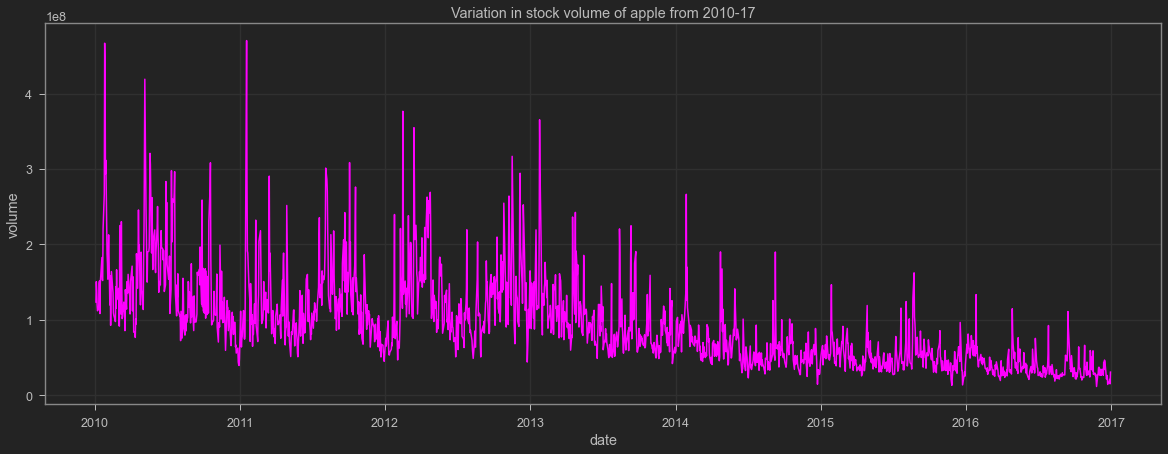

In [14]:
plt.figure(figsize=(20,7))
sns.lineplot(data=df1,x="date",y="volume",color="magenta").set_title("Variation in stock volume of apple from 2010-17")

**Statistical analysis of the numerical features w.r.t the apple stock data**

In [15]:
# defining a function to analyse the numerical features statistically
def feature_stats(df,feature):
    #creating the subplots
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    #adding the distribution plot
    sns.distplot(x=df[feature],kde=True,ax=ax[0],color="r").set_title("distribution plot of "+feature)
    #adding the probability plot
    stats.probplot(x=df[feature],plot=ax[1])
    #adding boxplot
    sns.boxplot(x=df[feature],ax=ax[2],color="g").set_title("boxplot of "+feature) 

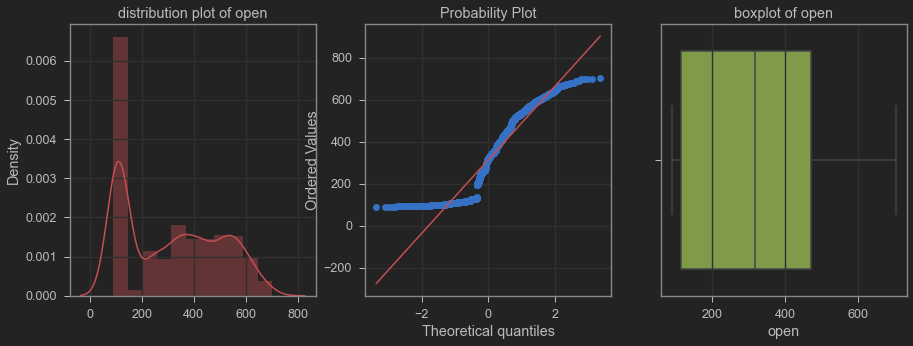

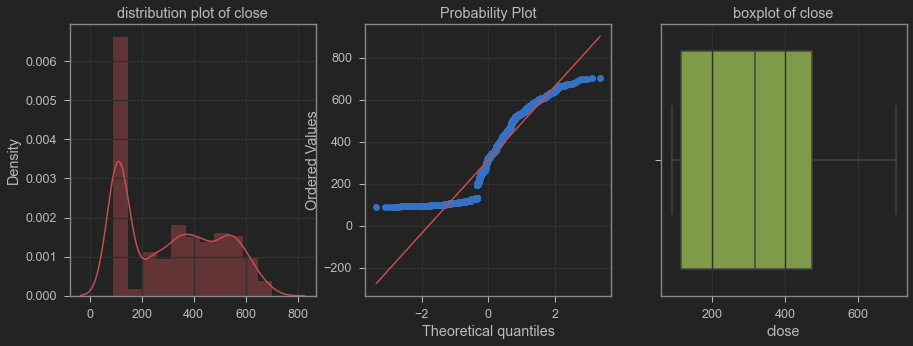

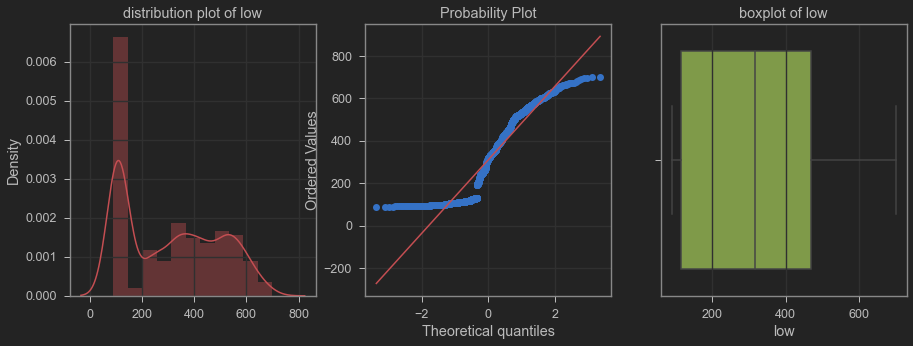

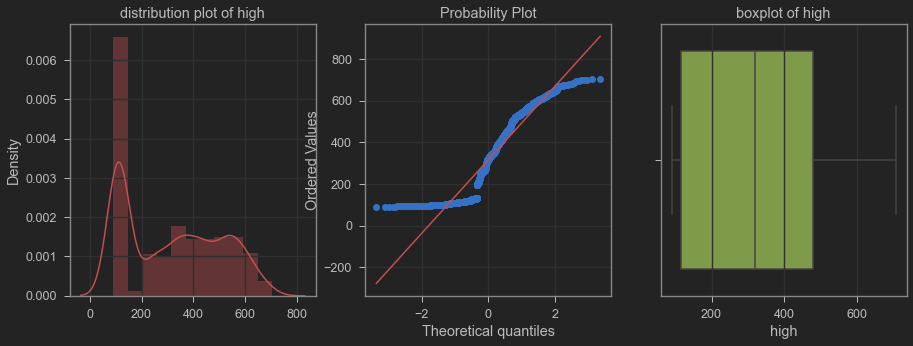

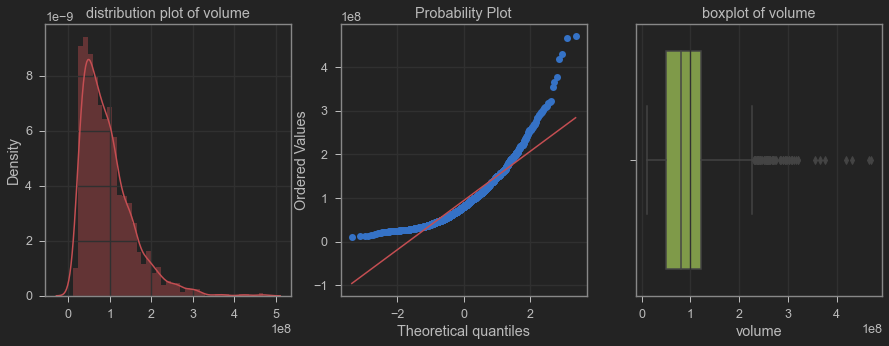

In [16]:
# dropping the non-numerical columns
df2=df1.drop("date",axis=1)
df2=df2.drop("symbol",axis=1)
# a for loop to apply the drfined function over all the features in df2
for i in df2.columns:
    feature_stats(df2,i)
    plt.show()

**Checking the correlation between the variables**


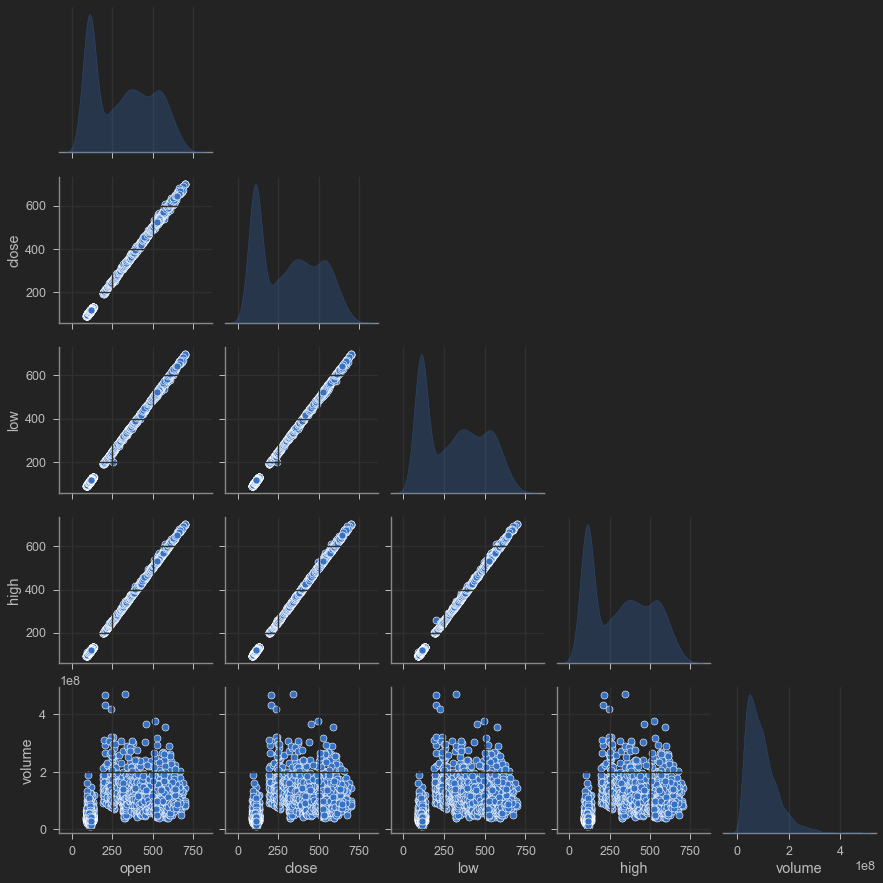

In [17]:
#generating pairplots betweeen the features to take a birds eye view
sns.pairplot(df2,corner=True,diag_kind="kde")

**now we want "close" as closing price to be our target variable so lets check our correlation of the other features with the target variable**

In [18]:
#correlation with features
df2.corr()["close"]

open      0.999650
close     1.000000
low       0.999834
high      0.999852
volume    0.408547
Name: close, dtype: float64

"open","low" and "high" are the feqatures which are mostly correlated to the targetet variable "close" i.e the closing price of the apple stocks

<AxesSubplot:>

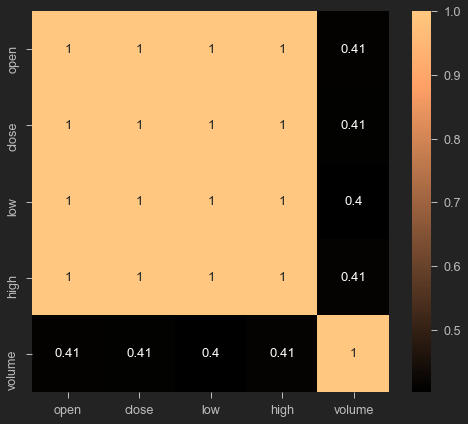

In [19]:
#checking correlation among all the variables
sns.heatmap(df2.corr(),annot=True,cmap="copper")

"high","low" and "open" are highly correlated.We need to avoid multicollinearity 

______________________________________________

In sequential models we use a different approach to create the dataset to feed into LSTM model

# Splitting the data

In [20]:
#splitting the data into input and target variables
x=df2[["open","volume","high","close"]]
y=df2["close"]
#splitting the data into train set and test set
training_set=x.iloc[:1300].values
test_set=x.iloc[1300:].values

___________________

# Normalization

In [21]:
#scaling the input features with the help of standard scaler
sc=StandardScaler()
training_set_scaled=sc.fit_transform(training_set)
test_set_scaled=sc.fit_transform(test_set)

__________________

### Creating the input for our model

making a data structure with 60 time steps and one output

In [22]:
# the model will look into past 100 timesteps predict the next feature and will continue to do so
length=100
#the training set creation
x_train=[]
y_train=[]
for i in range(length,len(training_set)):
    x_train.append(training_set_scaled[i-length:i,0])
    y_train.append(training_set_scaled[i,0])
#converting train set into array
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


# The testing set creation
x_test=[]
y_test=[]
for i in range(length,len(test_set)):
    x_test.append(test_set_scaled[i-length:i,0])
    y_test.append(test_set_scaled[i,0])
# converting test set into array
x_test,y_test=np.array(x_test),np.array(y_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [23]:
#checking the shape of the created datastructures
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((1200, 100, 1), (1200,), (362, 100, 1), (362,))

_______________________________

# Modelling 

#### Fitting the data into a lstm model

The LSTM model will learn a function that maps a sequence of past observations as input to an output observation. ... We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned

In [24]:
model=Sequential()
#adding the first layer with dropout regularization
model.add(LSTM(units=50,return_sequences=True,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
#adding second layer to the lstm model with dropout regularization
#model.add(LSTM(units=50,return_sequences=True))
#model.add(Dropout(0.2))
#adding the third layer with dropout regularization
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
#aedding the 4th layer alongwith dropout regularization
model.add(LSTM(units=50))
model.add(Dropout(0.2))
#adding the output layer
model.add(Dense(units=1))
#compiling the recurrent neural network model
model.compile(loss="mean_squared_error",optimizer="adam")
#fitting the model to the training set
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32)


Epoch 1/100
38/38 [==============================] - 23s 284ms/step - loss: 0.2275 - val_loss: 0.1997
Epoch 2/100
38/38 [==============================] - 8s 199ms/step - loss: 0.0850 - val_loss: 0.1727
Epoch 3/100
38/38 [==============================] - 8s 199ms/step - loss: 0.0724 - val_loss: 0.1313
Epoch 4/100
38/38 [==============================] - 7s 198ms/step - loss: 0.0629 - val_loss: 0.1319
Epoch 5/100
38/38 [==============================] - 8s 199ms/step - loss: 0.0541 - val_loss: 0.1084
Epoch 6/100
38/38 [==============================] - 8s 198ms/step - loss: 0.0538 - val_loss: 0.0976
Epoch 7/100
38/38 [==============================] - 8s 199ms/step - loss: 0.0501 - val_loss: 0.1075
Epoch 8/100
38/38 [==============================] - 8s 200ms/step - loss: 0.0431 - val_loss: 0.0895
Epoch 9/100
38/38 [==============================] - 7s 198ms/step - loss: 0.0430 - val_loss: 0.0940
Epoch 10/100
38/38 [==============================] - 8s 199ms/step - loss: 0.0421 - val_l

**Plotting the validation loss vs epochs**

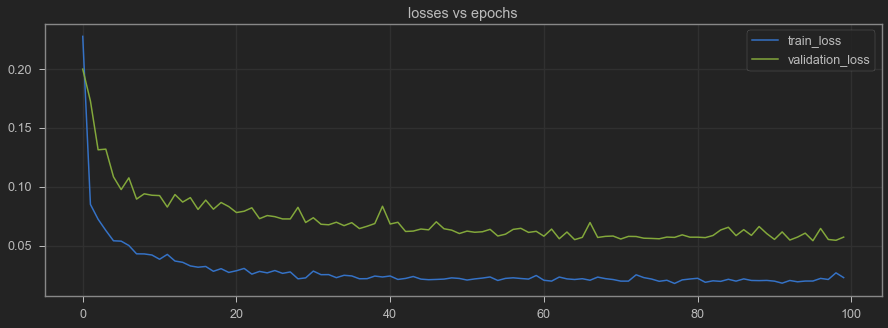

In [25]:
#creating the dataframe contaning the validation loss and  train_inver_transform
loss=pd.DataFrame(model.history.history)
plt.figure(figsize=(15,5))
plt.plot(loss)
plt.title("losses vs epochs")
plt.legend(["train_loss","validation_loss"])

**predicting the stock prices**

In [26]:
#creating a dataframe that consists of the test data and predicted data side by side in two columns
pred=model.predict(x_test)
test=pd.DataFrame(columns=["test","pred"])
test["test"]=y_test
test["pred"]=pred.flatten()
#checking the dataframne created
test.head(10)

,test,pred
0,1.060551,1.173213
1,1.039555,1.146749
2,0.963786,1.137934
3,0.989346,1.103054
4,0.888930,1.086012
5,0.516474,1.035221
6,0.108417,0.780998
7,0.384107,0.295874
8,0.257217,0.233349
9,0.435228,0.244898


**Plotting the test values vs the LSTM predicted values**

Text(320, -1.25, 'MSE:0.06')

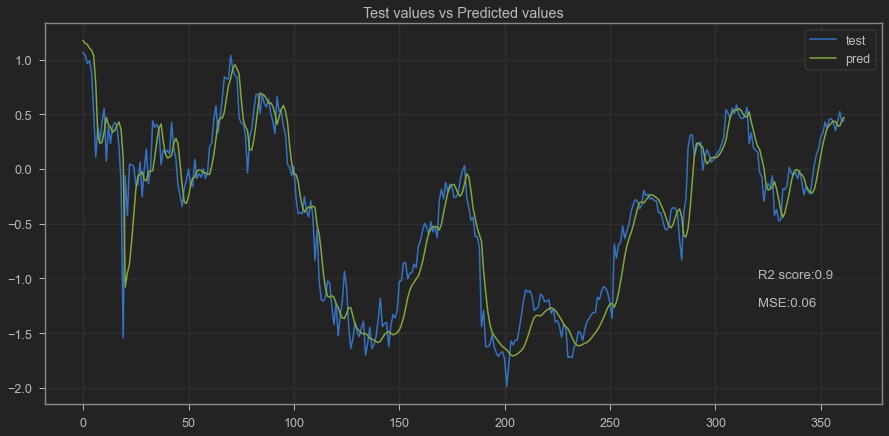

In [29]:
from sklearn.metrics import mean_squared_error,r2_score
#the lineplot
plt.figure(figsize=(15,7))
plt.plot(test)
plt.title("Test values vs Predicted values")
plt.legend(["test","pred"])
#calculating the losses
r2=np.round(r2_score(y_test,pred),2)
mse=np.round(mean_squared_error(y_test,pred),2)
#incorporating the losses in the plot
plt.text(x=320,y=-1.0,s="R2 score:{}".format(r2))
plt.text(x=320,y=-1.25,s="MSE:{}".format(mse))

the model is clearly overfitting and as a consequence the accuracy of the model gets affected,since we can't provide more company data,we take our chances and reduce the number of layers in the lstm model and check if th e model performace increases

**going for further accuracy enhancements**

In [30]:
model=Sequential()
#adding the first layer with dropout regularization
model.add(LSTM(units=50,return_sequences=True,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
#adding the next layer(2nd layer)
model.add(LSTM(units=50))
model.add(Dropout(0.2))
#adding the output layer
model.add(Dense(units=1))
#compiling the recurrent neural network model
model.compile(loss="mean_squared_error",optimizer="adam")
#fitting the model to the training set
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=30)

Epoch 1/100
40/40 [==============================] - 20s 272ms/step - loss: 0.1878 - val_loss: 0.1584
Epoch 2/100
40/40 [==============================] - 8s 212ms/step - loss: 0.0658 - val_loss: 0.1414
Epoch 3/100
40/40 [==============================] - 10s 240ms/step - loss: 0.0566 - val_loss: 0.1043
Epoch 4/100
40/40 [==============================] - 9s 231ms/step - loss: 0.0499 - val_loss: 0.0978
Epoch 5/100
40/40 [==============================] - 10s 243ms/step - loss: 0.0460 - val_loss: 0.0933
Epoch 6/100
40/40 [==============================] - 9s 223ms/step - loss: 0.0414 - val_loss: 0.0875
Epoch 7/100
40/40 [==============================] - 8s 213ms/step - loss: 0.0397 - val_loss: 0.0828
Epoch 8/100
40/40 [==============================] - 8s 188ms/step - loss: 0.0357 - val_loss: 0.0815
Epoch 9/100
40/40 [==============================] - 8s 196ms/step - loss: 0.0375 - val_loss: 0.0750
Epoch 10/100
40/40 [==============================] - 8s 199ms/step - loss: 0.0345 - val

Epoch 82/100
40/40 [==============================] - 5s 115ms/step - loss: 0.0217 - val_loss: 0.0466
Epoch 83/100
40/40 [==============================] - 4s 110ms/step - loss: 0.0203 - val_loss: 0.0487
Epoch 84/100
40/40 [==============================] - 4s 102ms/step - loss: 0.0215 - val_loss: 0.0461
Epoch 85/100
40/40 [==============================] - 5s 125ms/step - loss: 0.0213 - val_loss: 0.0492
Epoch 86/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0180 - val_loss: 0.0470
Epoch 87/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0216 - val_loss: 0.0460
Epoch 88/100
40/40 [==============================] - 4s 98ms/step - loss: 0.0194 - val_loss: 0.0454
Epoch 89/100
40/40 [==============================] - 4s 96ms/step - loss: 0.0209 - val_loss: 0.0467
Epoch 90/100
40/40 [==============================] - 4s 100ms/step - loss: 0.0189 - val_loss: 0.0468
Epoch 91/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0223 - v

Text(320, -1.25, 'MSE:0.05')

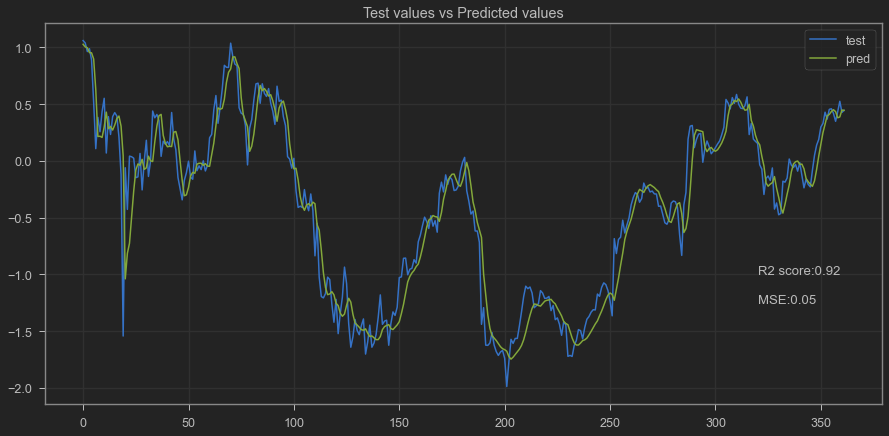

In [33]:
#creating a dataframe that consists of the test data and predicted data side by side in two columns
pred=model.predict(x_test)
test=pd.DataFrame(columns=["test","pred"])
test["test"]=y_test
test["pred"]=pred.flatten()
#the lineplot
plt.figure(figsize=(15,7))
plt.plot(test)
plt.title("Test values vs Predicted values")
plt.legend(["test","pred"])
#calculating the losses
r2=np.round(r2_score(y_test,pred),2)
mse=np.round(mean_squared_error(y_test,pred),2)
#incorporating the losses in the plot
plt.text(x=320,y=-1.0,s="R2 score:{}".format(r2))
plt.text(x=320,y=-1.25,s="MSE:{}".format(mse))